##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Binary snore detection model maker

In [1]:
!pip install -U -q tensorflow tensorflow_datasets
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 22.6 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package libcudnn8 is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source

E: Version '8.1.0.77-1+cuda11.2' for 'libcudnn8' was not found


In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
from google.colab import drive


In [4]:
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


The dataset consisting of 500 background noises and 500 snoring noises was uploaded to my google drive. You can get the dataset from https://www.kaggle.com/datasets/tareqkhanemu/snoring

In [5]:
DATASET_PATH = 'drive/MyDrive/SpeechTraining/dataset'

data_dir = pathlib.Path(DATASET_PATH)


In [6]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
print('Commands:', commands)

Commands: ['background' 'snoring']


The code below downsamples 44.1 kHz audio sample to 8 kHz, which is what's needed for the microcontroller to be fast.

In [ ]:
import librosa
import soundfile as sf
# Your new sampling rate
new_rate = 16000
for file in os.listdir('drive/MyDrive/SpeechTraining/dataset/background'):
  y, s = librosa.load('drive/MyDrive/SpeechTraining/dataset/background/'+file, sr=new_rate) # Downsample 44.1kHz to 8kHz
  sf.write('drive/MyDrive/SpeechTraining/dataset/background/'+file, y, new_rate, 'PCM_16')
for file in os.listdir('drive/MyDrive/SpeechTraining/dataset/snoring'):
  y, s = librosa.load('drive/MyDrive/SpeechTraining/dataset/snoring/'+file, sr=new_rate) # Downsample 44.1kHz to 8kHz
  sf.write('drive/MyDrive/SpeechTraining/dataset/snoring/'+file, y, new_rate, 'PCM_16')

Exception ignored on calling ctypes callback function: <function ExecutionEngine._raw_object_cache_notify at 0x7fd066bc0550>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/llvmlite/binding/executionengine.py", line 171, in _raw_object_cache_notify
    def _raw_object_cache_notify(self, data):
KeyboardInterrupt: 


RuntimeError: ignored

In [7]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 1000 files belonging to 2 classes.
Using 800 files for training.
Using 200 files for validation.

label names: ['background' 'snoring']


The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`.

This dataset only contains single channel audio, so use the `tf.squeeze` function to drop the extra axis:

In [8]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)


In [9]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [10]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


Let's plot a few audio waveforms:

In [ ]:
label_names[[1,1]]

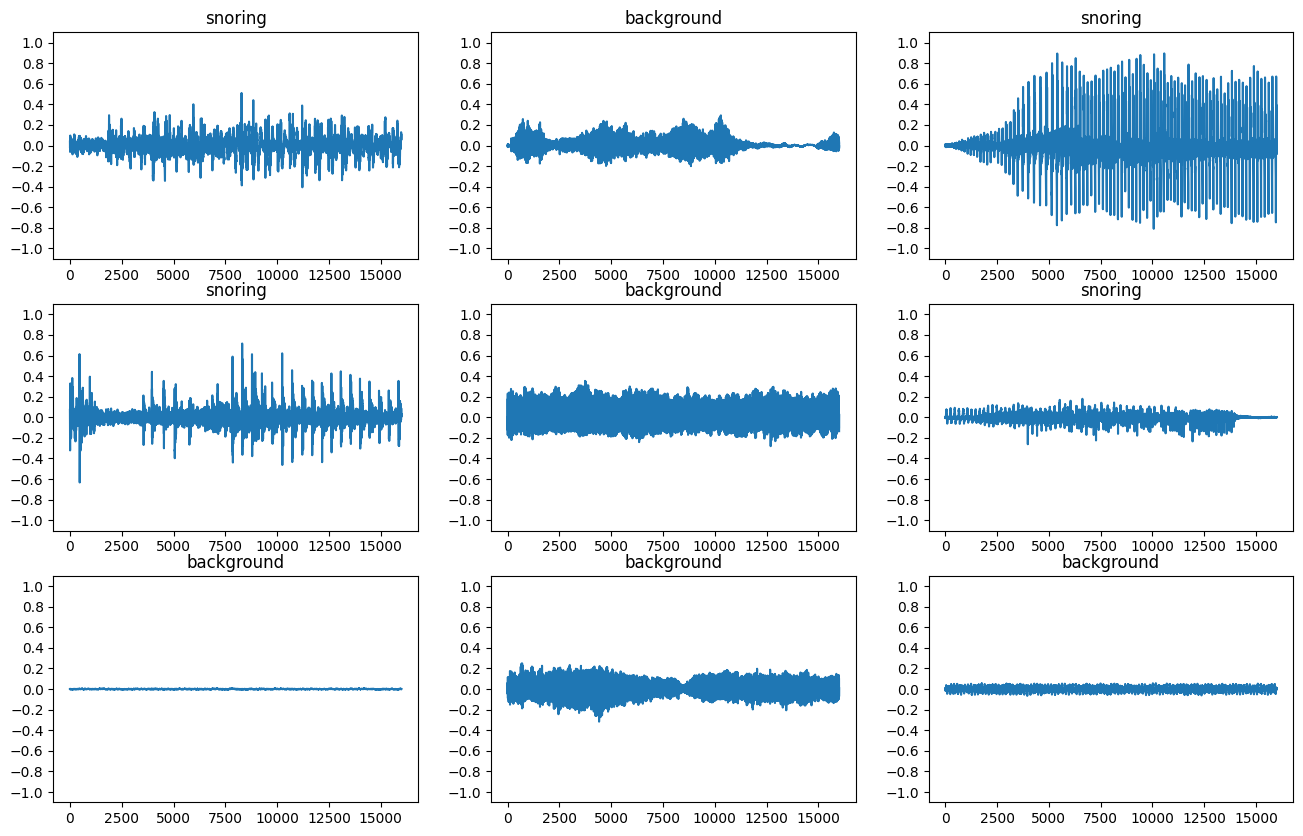

In [ ]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

## Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the [short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) to convert the waveforms to as [spectrograms](https://en.wikipedia.org/wiki/Spectrogram), which show frequency changes over time and can be represented as 2D images.

Additionally, we will apply log scale and mel-scale to these spectrograms to reduce the data size.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to [this Coursera video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing and STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [11]:
def get_log_mel(waveform):
  stfts = tf.signal.stft(
      waveform, frame_length=512, frame_step=256)
  # Obtain the magnitude of the STFT.
  spectrograms = tf.abs(stfts)
  # Warp the linear scale spectrograms into the mel-scale.
  num_spectrogram_bins = stfts.shape[-1]
  lower_edge_hertz, upper_edge_hertz, num_mel_bins = 40.0, 6000.0, 30
  linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins, num_spectrogram_bins, 16000, lower_edge_hertz,
    upper_edge_hertz)
  mel_spectrograms = tf.tensordot(
    spectrograms, linear_to_mel_weight_matrix, 1)
  mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(
    linear_to_mel_weight_matrix.shape[-1:]))

  # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
  log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)
  log_mel_spectrograms = tf.reshape(log_mel_spectrograms, [-1,1830])
  return log_mel_spectrograms

In [12]:
def get_log_mel_not_flat(waveform):
  stfts = tf.signal.stft(
      waveform, frame_length=512, frame_step=256)
  # Obtain the magnitude of the STFT.
  spectrograms = tf.abs(stfts)
  # Warp the linear scale spectrograms into the mel-scale.
  num_spectrogram_bins = stfts.shape[-1]
  lower_edge_hertz, upper_edge_hertz, num_mel_bins = 40.0, 6000.0, 30
  linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins, num_spectrogram_bins, 16000, lower_edge_hertz,
    upper_edge_hertz)
  mel_spectrograms = tf.tensordot(
    spectrograms, linear_to_mel_weight_matrix, 1)
  mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(
    linear_to_mel_weight_matrix.shape[-1:]))

  # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
  log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)
  log_mel_spectrograms = log_mel_spectrograms[..., tf.newaxis]
  return log_mel_spectrograms

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

Label: snoring
Waveform shape: (16000,)
log mel shape: (61, 30, 1)
Audio playback


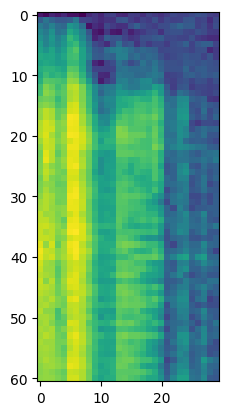

In [18]:
  label = label_names[example_labels[2]]
  waveform = example_audio[2]
  log_mel = get_log_mel_not_flat(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('log mel shape:', log_mel.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))
  plt.imshow(log_mel)

Now, create spectrogramn datasets from the audio datasets:

In [19]:
def make_log_mel_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_log_mel(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)
def make_log_mel_not_flat_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_log_mel_not_flat(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [15]:
train_log_mel_ds = make_log_mel_ds(train_ds)
val_log_mel_ds = make_log_mel_ds(val_ds)
test_log_mel_ds = make_log_mel_ds(test_ds)
train_log_mel_not_flat_ds = make_log_mel_not_flat_ds(train_ds)

Examine the spectrograms for different examples of the dataset:

In [16]:
for example_log_mels, example_lm_labels in train_log_mel_ds.take(1):
  break

## Build and train the model

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [17]:
train_log_mel_ds = train_log_mel_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_log_mel_ds = val_log_mel_ds.cache().prefetch(tf.data.AUTOTUNE)
test_log_mel_ds = test_log_mel_ds.cache().prefetch(tf.data.AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.

Your `tf.keras.Sequential` model will use the following Keras preprocessing layers:

- `tf.keras.layers.Resizing`: to downsample the input to enable the model to train faster.
- `tf.keras.layers.Normalization`: to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [20]:
input_shape = example_log_mels.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_log_mel_not_flat_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Reshape((61,30,1)),
    # Downsample the input.
    layers.Resizing(32, 30),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D((2,2)),
    # layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid'),
])

model.summary()

Input shape: (1830,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 61, 30, 1)         0         
                                                                 
 resizing (Resizing)         (None, 32, 30, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 30, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None,

Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [21]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Train the model over 10 epochs for demonstration purposes:

In [22]:
EPOCHS = 11
history = model.fit(
    train_log_mel_ds,
    validation_data=val_log_mel_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/11


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


13/13 [==============================] - 26s 2s/step - loss: 0.6499 - accuracy: 0.6112 - val_loss: 0.5402 - val_accuracy: 0.7917
Epoch 2/11
13/13 [==============================] - 1s 73ms/step - loss: 0.4783 - accuracy: 0.7725 - val_loss: 0.3027 - val_accuracy: 0.9167
Epoch 3/11
13/13 [==============================] - 1s 75ms/step - loss: 0.2772 - accuracy: 0.9000 - val_loss: 0.1996 - val_accuracy: 0.9722
Epoch 4/11
13/13 [==============================] - 1s 94ms/step - loss: 0.1897 - accuracy: 0.9312 - val_loss: 0.1374 - val_accuracy: 0.9583
Epoch 5/11
13/13 [==============================] - 2s 122ms/step - loss: 0.1761 - accuracy: 0.9388 - val_loss: 0.1201 - val_accuracy: 0.9861
Epoch 6/11
13/13 [==============================] - 2s 119ms/step - loss: 0.1158 - accuracy: 0.9625 - val_loss: 0.1168 - val_accuracy: 0.9861
Epoch 7/11
13/13 [==============================] - 2s 119ms/step - loss: 0.0842 - accuracy: 0.9762 - val_loss: 0.1064 - val_accuracy: 0.9722
Epoch 8/11
13/13 [====

Let's plot the training and validation loss curves to check how your model has improved during training:

Text(0, 0.5, 'Accuracy [%]')

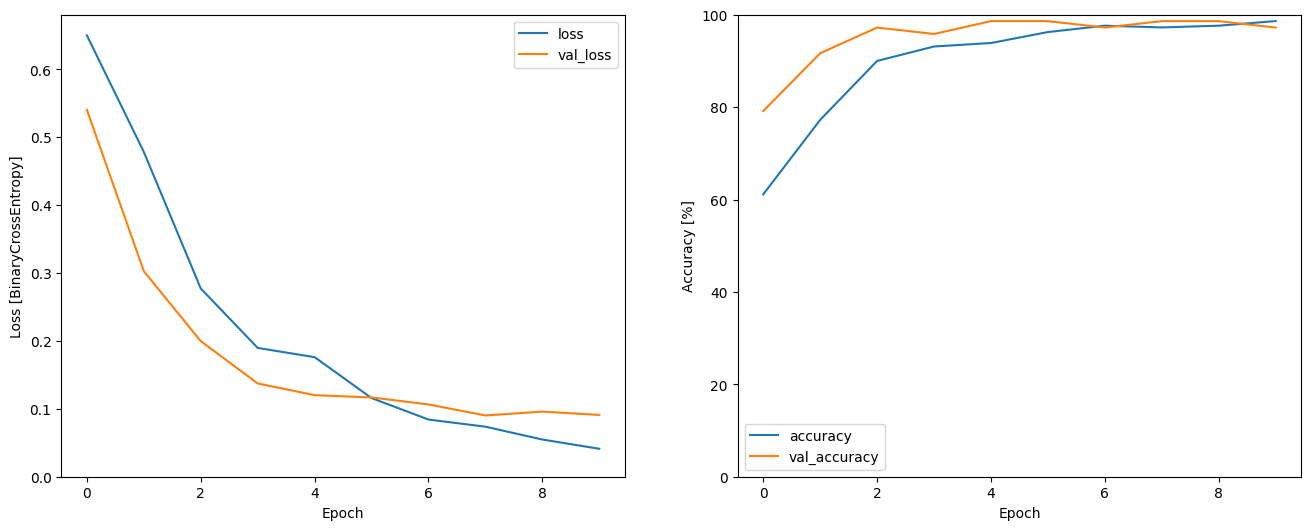

In [25]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [BinaryCrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [26]:
model.evaluate(test_log_mel_ds, return_dict=True)
model.evaluate(val_log_mel_ds, return_dict=True)
model.evaluate(train_log_mel_ds, return_dict=True)

13/13 [==============================] - 0s 23ms/step - loss: 0.0213 - accuracy: 0.9950


{'loss': 0.021274901926517487, 'accuracy': 0.9950000047683716}

### Display a confusion matrix

Use a [confusion matrix](https://developers.google.com/machine-learning/glossary#confusion-matrix) to check how well the model did classifying each of the commands in the test set:


In [27]:
def classify_snoring(model, preprocessed_audio, threshold=0.5):
    # Run inference on the preprocessed audio
    prediction = model.predict(np.expand_dims(preprocessed_audio, axis=0))
    probability = prediction[0, 0]

    # Apply a threshold to determine snoring or non-snoring
    if probability >= threshold:
        return "Snoring"
    else:
        return "Non-Snoring"

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

In [28]:
x = data_dir/'background/0_300.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_log_mel(x)

prediction = model(x)
probability = prediction[0, 0]
print(probability)

tf.Tensor(0.0024485854, shape=(), dtype=float32)


In [29]:
def representative_dataset():
  for spectogram, label in train_log_mel_ds.take(100):
    yield [tf.dtypes.cast(spectogram, tf.float32)]


In [30]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model = converter.convert()

# Save the model.
with open('drive/MyDrive/SpeechTraining/model.tflite', 'wb') as f:
  f.write(tflite_model)
!ls

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


drive  sample_data


In [31]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file

!xxd -i ./drive/MyDrive/SpeechTraining/model.tflite > ./drive/MyDrive/SpeechTraining/model.cc
# Update variable names
MODEL_TFLITE = os.path.join('drive/MyDrive/SpeechTraining', 'drive/MyDrive/SpeechTraining/model.tflite')
MODEL_TFLITE_MICRO = os.path.join('drive/MyDrive/SpeechTraining', 'drive/MyDrive/SpeechTraining/model.cc')

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [966 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [993 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [498 kB]
Get:13 http://archiv